In [344]:
# LSTM for closing bitcoin price with regression framing

In [345]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math

In [346]:
import os

In [347]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [348]:
# convert an array of values into a dataset matrix

In [349]:
def create_dataset(dataset):
  dataX, dataY = [], []
  for i in range(len(dataset)-1):
    dataX.append(dataset[i])
    dataY.append(dataset[i + 1])
  return np.asarray(dataX), np.asarray(dataY)

In [350]:
# fix random seed for reproducibility

In [351]:
np.random.seed(7)

In [352]:
# load the dataset
df = pd.read_csv('crypto.csv', index_col='date', parse_dates=True)

In [353]:
bitcoin_price = df[df['name']=='Bitcoin']
bitcoin_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2013-04-28 to 2018-02-21
Data columns (total 12 columns):
slug           1761 non-null object
symbol         1761 non-null object
name           1761 non-null object
ranknow        1761 non-null int64
open           1761 non-null float64
high           1761 non-null float64
low            1761 non-null float64
close          1761 non-null float64
volume         1761 non-null int64
market         1761 non-null int64
close_ratio    1761 non-null float64
spread         1761 non-null float64
dtypes: float64(6), int64(3), object(3)
memory usage: 178.9+ KB


In [354]:

bitcoin_price = bitcoin_price.iloc[::-1]
df = bitcoin_price.drop(['ranknow','symbol','slug','name','open','high','low','volume','market','close_ratio','spread'], axis=1)
dataset = df.values
dataset = dataset.astype('float32')


In [355]:
dataset

array([[ 10690.40039062],
       [ 11403.70019531],
       [ 11225.29980469],
       ..., 
       [   139.        ],
       [   144.53999329],
       [   134.21000671]], dtype=float32)

LSTMs are sensitive to the scale of the input data. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library

In [356]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

The function takes one argument: the dataset, which is a NumPy array that we want to convert into a dataset. This function will create a dataset where X is the closing price of Bitcoin at a given time (t) and Y is the closing price of Bitcoin at the next time (t+1).

In [357]:
#prepare the X and Y label

In [358]:
X,y = create_dataset(dataset)

In [359]:
#Take 80% of data as the training sample and 20% as testing sample

In [360]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20)

The shape of the input data (X) for the LSTM network should be specifically in the form of [samples, time steps, features].<br>
Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using np.reshape() as follows:

In [362]:
# reshape input to be [samples, time steps, features]

In [363]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design the LSTM model for our problem. The network has 1 input layer, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The LSTM blocks use sigmoid activation function by default. We train the network for 5 epochs and use a batch size of 1. Once trained, you can save the model using the model.save method. You can also use the load_model method to load a pre-trained model.

In [365]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [366]:
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
 - 15s - loss: 0.0062
Epoch 2/5
 - 13s - loss: 2.3749e-04
Epoch 3/5
 - 13s - loss: 2.6571e-04
Epoch 4/5
 - 13s - loss: 2.8389e-04
Epoch 5/5
 - 13s - loss: 2.4526e-04


We can estimate the performance of the model on the train and test datasets once the model is fit. This will give us a point of comparison for new models.



In [367]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [368]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [371]:
trainPredict

array([[  952.79559326],
       [ 1194.88720703],
       [  504.54452515],
       ..., 
       [  618.54730225],
       [  436.20098877],
       [ 4444.22607422]], dtype=float32)

In [372]:
print("Price for last 5 days: ")
print(testPredict[-5:])
futurePredict = model.predict(np.asarray([[testPredict[-1]]]))
futurePredict = scaler.inverse_transform(futurePredict)
print("Bitcoin price for tomorrow: ", futurePredict)

Price for last 5 days: 
[[ 7561.40771484]
 [  191.52043152]
 [  748.2052002 ]
 [  459.39141846]
 [  163.78808594]]
Bitcoin price for tomorrow:  [[ 191080.625]]


In [376]:
mse = ((testPredict - testY) ** 2).mean(axis=None)
rmse = mse**0.5

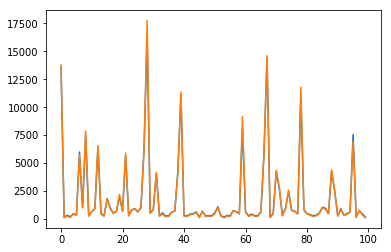

In [378]:
plt.plot(testPredict[-100:])
plt.plot(testY[-100:])
plt.show()